In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
#interactive matplotlib
# %matplotlib widget 

In [4]:
plotly.offline.init_notebook_mode()

#### Derivative functions assume that the first entry in a "state" array is the independent variable (usually t), and the rest follow a standard order for each set of diffeqs

In [5]:
def derivs_Rossler(state):
    a = b = 0.2
    c = 5.7
    result = np.copy(state)
    dxdt = -1*(state[2] + state[3])
    dydt = state[1] + a*state[2]
    dzdt = b + state[3]*(state[1] - c)
    result[0] = state[0] #the independent variable
    result[1] = dxdt
    result[2] = dydt
    result[3] = dzdt
    return result

In [6]:
def derivs_harmonic(state):
    w = 1.0
    result = np.copy(state)
    result[0] = state[0]
    result[1] = state[2]
    result[2] = -w*w*state[1]
    return result

In [7]:
def derivs_Lorenz(state):
    sig = 10.0
    rho = 28.0
    bet = 8*.333333
    result = np.copy(state)
    result[1] = sig*(state[2] - state[1])
    result[2] = state[1]*(rho-state[3]) - state[2]
    result[3] = state[1]*state[2] - bet*state[3]
    result[0] = state[0] #the independent variable
    return result

In [8]:
def rk4_step(state, state_derivs, h, deriv_func):
    n = len(state)
    state_half_k1 = np.copy(state)
    state_half_k2 = np.copy(state)
    state_k3 = np.copy(state)
    new_state = np.copy(state)
    indep_var_half = state[0] + 0.5*h #x_n + 0.5*h
    indep_var_full = state[0] + h #x_n + h
    state_half_k1[0] = indep_var_half
    for i in range(1,n):
        #y_n + 0.5*k_1 = y_n + 0.5*h*f(x_n, y_n)
        state_half_k1[i] = state[i] + (state_derivs[i]*0.5*h)
    #k_2 = h*f(x_n + 0.5*h, y_n + 0.5*k1)
    k_2 = deriv_func(state_half_k1)
    state_half_k2[0] = indep_var_half
    for i in range(1,n):
        #y_n + 0.5*k_2 = y_n + 0.5*h*f(x_n +0.5*h, y_n + 0.5*k2)
        state_half_k2[i] = state[i] + h*k_2[i]*0.5
    #k_3 = h*f(x_n + 0.5*h, y_n + 0.5*k2)
    k_3 = deriv_func(state_half_k2)
    state_k3[0] = indep_var_full
    for i in range(1,n):
        #y_n + k_3 = y_n + h*f(x_n + h, y_n + k_3)
        state_k3[i] = state[i] + h*k_3[i]
    k_4 = deriv_func(state_k3)
    for i in range(1,n):
        #y_(n+1) = y_n + k_1/6 + k_2/3 + k_3/3 + k4/6 + O(h^5)
        new_state[i] = state[i] + (h/6.0)*(state_derivs[i] + 2*(k_2[i] + k_3[i]) + k_4[i])
    new_state[0] = indep_var_full
    return new_state

In [9]:
#create a more generic rk4 driver for constant step size
#no error checking/input cleaning
#tmin is state_init[0] as the starting independent variable
#returns full data across all variables through tmin
#output[:,0] = t; output[:,1] = x(t); ...
def ghk_rk4(tmax, state_init, h, deriv_func):
    points = int((tmax-state_init[0])/h)
    derivs_init = deriv_func(state_init)
    state_storage = np.empty((0,len(state_init))) #create 2d array
    state_storage = np.append(state_storage,[state_init],axis=0) #initial state
    old_state = np.copy(state_init) #used to generate next state
    next_state = np.copy(state_init) #stores new calculated state
    old_derivs = np.copy(derivs_init) #used to generate next state
    for j in range(0,points-1):
        old_state = next_state
        old_derivs = deriv_func(next_state)
        next_state = rk4_step(old_state,old_derivs,h,deriv_func)
        state_storage = np.append(state_storage,[next_state],axis=0)
    return state_storage    

In [10]:
harmonic_data = ghk_rk4(5*np.pi, [0.0,1.0,0.0], .01, derivs_harmonic)

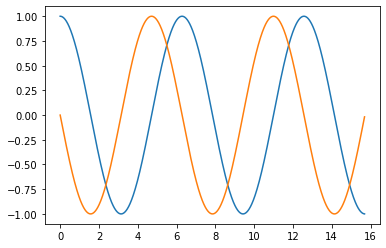

In [11]:
plt.plot(harmonic_data[:,0],harmonic_data[:,1]);
plt.plot(harmonic_data[:,0],harmonic_data[:,2]);

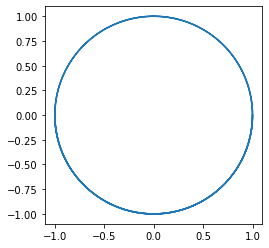

In [12]:
plt.plot(harmonic_data[:,1],harmonic_data[:,2]);
plt.axis('square');

In [13]:
#make 3d plot of chaotic system data for rossler and lorenz systems
# copied from https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook
# and https://plotly.com/python/3d-line-plots/
def plot_3d_custom(data_3d):
    # Configure the trace.
    trace = go.Scatter3d(
        x=data_3d[:,1],  # <-- Put your data instead
        y=data_3d[:,2],  # <-- Put your data instead
        z=data_3d[:,3],  # <-- Put your data instead
        mode='lines',
#         marker={
#             'size': 2,
#             'opacity': 0.8,
#         },
        line=dict(
        color='darkblue',
        width=2
        )
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)

In [14]:
rossler_data = ghk_rk4(200, [0.0, 0.0, -6.78, 0.02], .01, derivs_Rossler)

In [15]:
plot_3d_custom(rossler_data)

In [16]:
lorenz_data = ghk_rk4(50, [0.0, 1.0, 1.0, 1.0], .01, derivs_Lorenz)

In [17]:
plot_3d_custom(lorenz_data)

In [18]:
# fig, axs = plt.subplots(3, 1, figsize=(10,25))
# axs[0].plot(lorenz_data[:,1], lorenz_data[:,2]);
# axs[0].set_title('$x(t)$ vs $y(t)$');
# axs[0].axis('square');
# axs[1].plot(lorenz_data[:,1], lorenz_data[:,3]);
# axs[1].set_title('$x(t)$ vs $z(t)$');
# axs[1].axis('square');
# axs[2].plot(lorenz_data[:,2], lorenz_data[:,3]);
# axs[2].set_title('$y(t)$ vs $z(t)$');
# axs[2].axis('square');

In [19]:
# fig, axs = plt.subplots(3, 1, figsize=(10,25))
# axs[0].plot(rossler_data[:,1], rossler_data[:,2]);
# axs[0].set_title('$x(t)$ vs $y(t)$');
# axs[0].axis('square');
# axs[1].plot(rossler_data[:,1], rossler_data[:,3]);
# axs[1].set_title('$x(t)$ vs $z(t)$');
# axs[1].axis('square');
# axs[2].plot(rossler_data[:,2], rossler_data[:,3]);
# axs[2].set_title('$y(t)$ vs $z(t)$');
# axs[2].axis('square');

In [20]:
# plot3d = plt.axes(projection='3d');
# plot3d.plot3D(lorenz_data[:,1],lorenz_data[:,2],lorenz_data[:,3]);
# plot3d.view_init(20,160)